In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

pd.set_option("display.float_format", lambda x: "%.8f" % x)

%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

---
# Fetching decoded ADS-B data from OpenSky

In [2]:
from pymodes_opensky import OpenskyImpalaWrapper

osw = OpenskyImpalaWrapper()

**Server connection successful!


<IPython.core.display.Javascript object>

## Example flight (AMS-BEG, 09/09, AS 361)

In [3]:
adsb = osw.query(
    type="adsb", start="2019-09-09 08:00:00", end="2019-09-09 12:30:00", icao24="4C01E4"
)

**Obtaining details of the query...
**OpenSky Impala: 6158 of records found.
**Fetching records...
**Records downloaded.


<IPython.core.display.Javascript object>

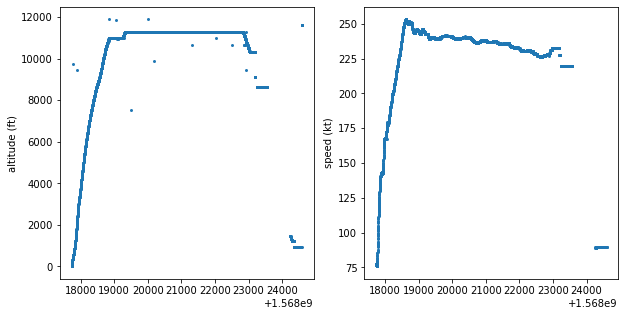

<IPython.core.display.Javascript object>

In [4]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.scatter(adsb.time, adsb.baroaltitude, marker=".", lw=0)
plt.ylabel("altitude (ft)")

plt.subplot(122)
plt.scatter(adsb.time, adsb.velocity, marker=".", lw=0)
plt.ylabel("speed (kt)")
plt.show()

---
# Fetch and decode RAW Mode-S data from OpenSky

## Download RAW data only

In [5]:
df_raw = osw.query(
    type="raw", start="2019-09-09 08:00:00", end="2019-09-09 12:30:00", icao24="4C01E4"
)

**Obtaining details of the query...
**OpenSky Impala: 31944 of records found.
**Fetching records...
**Records downloaded.


<IPython.core.display.Javascript object>

In [6]:
print(df_raw.columns.tolist())

['rawmsg', 'mintime', 'maxtime', 'msgcount', 'icao24', 'message', 'isid', 'flightstatus', 'downlinkrequest', 'utilitymsg', 'interrogatorid', 'identifierdesignator', 'valuecode', 'altitude', 'identity', 'hour']


<IPython.core.display.Javascript object>

## Download and decode Comm-B data (slow when there are many rows)

In [7]:
from pymodes_opensky import EHSHelper

ehs = EHSHelper()

df_ehs = ehs.get(
    start="2019-09-09 08:00:00", end="2019-09-09 12:30:00", icao24="4C01E4"
)

**Server connection successful!
**Obtaining details of the query...
**OpenSky Impala: 31944 of records found.
**Fetching records...
**Records downloaded.
**Processing data...


<IPython.core.display.Javascript object>

In [8]:
print(df_ehs.columns.tolist())

['icao24', 'time', 'rawmsg', 'bds', 'altitude', 'squawk', 'selalt40mcp', 'selalt40fms', 'p40baro', 'roll50', 'trk50', 'rtrk50', 'gs50', 'tas50', 'ias60', 'hdg60', 'mach60', 'vr60baro', 'vr60ins']


<IPython.core.display.Javascript object>

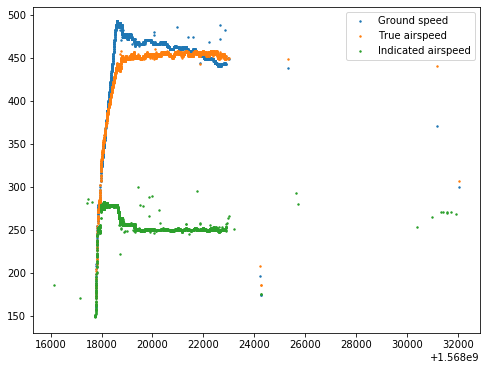

<IPython.core.display.Javascript object>

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(df_ehs.time, df_ehs.gs50, label="Ground speed", s=2)
plt.scatter(df_ehs.time, df_ehs.tas50, label="True airspeed", s=2)
plt.scatter(df_ehs.time, df_ehs.ias60, label="Indicated airspeed", s=2)
plt.legend()
plt.show()

---
# Fetch and visualize data from OpenSky with `traffic`

In [10]:
from traffic.core import Traffic
from traffic.data import opensky

/home/junzi/miniconda3/envs/py37/lib/python3.7/site-packages/jinja2/utils.py:485: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/home/junzi/miniconda3/envs/py37/lib/python3.7/site-packages/jinja2/runtime.py:318: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
/home/junzi/miniconda3/envs/py37/lib/python3.7/site-packages/pkg_resources/__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
/home/junzi/miniconda3/envs/py37/lib/python3.7/site-packages/ipyleaflet/leaflet.py:92: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in 

<IPython.core.display.Javascript object>

In [11]:
t = opensky.history(
    start="2019-09-09 08:00:00", stop="2019-09-09 12:30:00", icao24="4c01e4"
)

<IPython.core.display.Javascript object>

In [12]:
t

,,count
icao24,callsign,
4c01e4,ASL20Z,5463


<IPython.core.display.Javascript object>

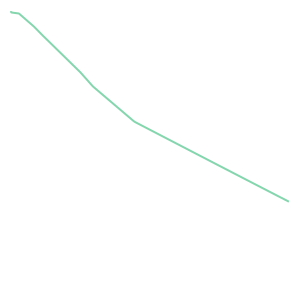

<IPython.core.display.Javascript object>

In [13]:
t["ASL20Z"]

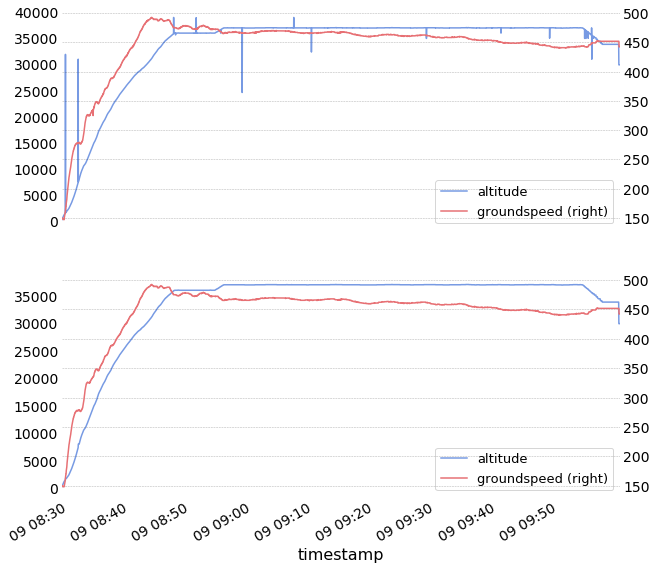

<IPython.core.display.Javascript object>

In [14]:
with plt.style.context("traffic"):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    t["ASL20Z"].plot_time(ax1, ["altitude", "groundspeed"], "groundspeed")
    t["ASL20Z"].filter().plot_time(ax2, ["altitude", "groundspeed"], "groundspeed")

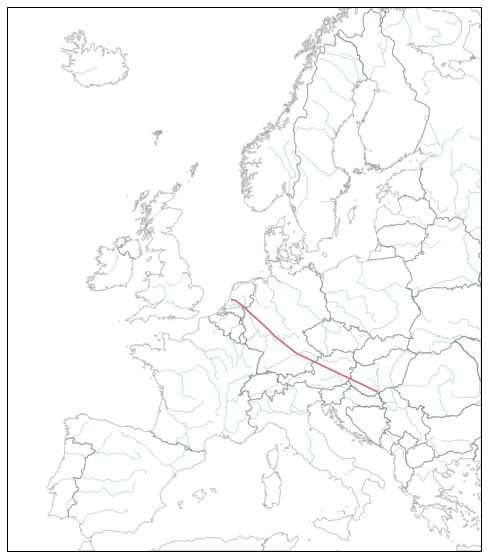

<IPython.core.display.Javascript object>

In [15]:
from traffic.drawing import EuroPP, rivers, countries

with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries(edgecolor="#524c50", alpha=0.3))
    ax.add_feature(rivers(alpha=0.2))
    ax.set_global()

    # The map becomes too noisy if we plot everything
    t.plot(ax, nb_flights=100)

    # Plot a specific flight
    t["ASL20Z"].plot(ax)

In [16]:
from ipyleaflet import Map, basemaps
from ipywidgets import Layout

map_ = Map(
    center=(48.1, 11.5),
    zoom=5,
    basemap=basemaps.Stamen.Terrain,
    layout=Layout(width="100%", max_width="800px", height="500px"),
)

map_.add_layer(t["ASL20Z"], color="#990000", weight=2)

map_

Map(basemap={'url': 'https://stamen-tiles-a.a.ssl.fastly.net/terrain/{z}/{x}/{y}.png', 'attribution': 'Map til…

<IPython.core.display.Javascript object>